# Transformer Chatbot

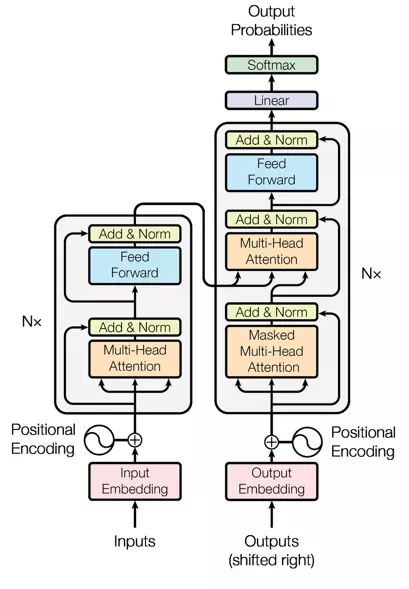

**Input embedding**
Đầu vào của khối encoder đầu tiên là các vector embeddings của các từ trong câu. Đầu vào của các khối encoder còn lại là đầu ra của khối endcoder phía dưới. Các embeddings được tạo thành từ việc kết hợp vector word embedding + positional embedding.

Vector word embedding là vector biểu diễn các từ được tạo ra từ các pre-model như word2vec, glove…
Vector positional embedding là vector biểu diễn thứ tự của các từ trong chuỗi, chúng mang thông tin về vị trí và khoảng cách của các từ. Nếu không có thông tin này việc học biểu diễn cho câu “Trời hôm nay trở lạnh vì gió mùa tràn về” và câu “về tràn gió mù trở lạnh vì hôm nay Trời” sẽ không có gì khác biệt. Rõ ràng vị trí của các từ mang ý nghĩa quan trọng, việc thay đổi vị trí của một từ cũng có thể làm thay đổi ý nghĩa của cả câu. Vector positional embedding(PE) được tính theo công thức:

Trong đó dmodel là số chiều của vector, pos là số vị trí(0, 1, 2, 3….), i là chiều thứ i của vector(i ∈ 0, 1, 2...dmodel)

**Layer self-attention**<br>
Phép tính đầu tiên trong sef-attention là nhân mỗi vector embedding đầu vào với 3 ma trận trọng số Wq, Wk, Wv để tạo ra 3 vector q, k v. Các ma trận trọng số này sẽ được cập nhật trong quá trình đào tạo. Vector q và k được dùng để tính trọng số khuếch đại thông tin cho các từ trong câu. Vector v là vector biểu diễn của các từ trong câu.

Ví dụ ta có 2 vector embeddings(tương ứng với 2 từ đầu vào “Trời”, “lạnh”) là x1, x2. Nhân 2 vector này với 3 ma trân Wq, Wk, Wv ta được tập các vector: {q1, q2}, {k1, k2}, {v1, v2}. Để tính toán vector biểu diễn cho từ “Trời”. Đầu tiên ta cần tính trọng số khuếch đại thông tin cho mỗi từ(gọi là Attention), Attention cho từ “Trời”(a1) và từ “lạnh”(a2) được tính theo công thức sau:

a1 = softmax(q1*k1/√d)
a2 = softmax(q1*k2/√d)
Trong đó d là số chiều của vector k. Cuối cùng vector biểu diễn cho từ “Trời” được tính theo công thức:

z1 = a1*v1 + a2*v2
Tương tự việc tính toán vector biểu diễn cho các từ còn lại cũng được thực hiện như trên. Việc sử dụng multi-gpu để thực hiện các phép tính song song không được thực hiện ở bước này vì để tính được vector z của 1 từ ta cần có vector k và v của các từ khác.

**Multi-Head Attention** <br>
Kiến trúc transformer được thiết kế với 8 lớp self-attention kiến trúc giống hệt nhau nhưng trọng số của 3 ma trận Q, K, V khác nhau. Việc tính toán của 8 layer này được thực hiện song song. Các vector biểu diễn qua mỗi lớp self-attention sẽ được nối lại với nhau sau đó được nhân với một ma trận trọng số Wo để nén thông tin từ 8 vector(8 vector này cùng biểu diễn cho 1 từ) thành một vector duy nhất. Vector này sau đó đi qua một bước gọi là Add & Normalize nữa trước khi đưa vào layer Feed Forward.

Ý nghĩa của cơ chế multi-head này là để tăng thêm phần chắc chắn trong việc quyết định thông tin nào cần khuếch đại, thông tin nào cần bỏ qua. Vì rằng 8 cái đầu sẽ cùng vote và đưa ra lựa chọn khách quan, đáng tin cậy hơn 1 cái đầu.

**Position-wise Feed-Forward Networks(FFN)**<br>
Các vector sau khi đi qua bước Add & Normalize(sẽ được nói ở mục sau) sẽ được gửi tới FFN. Lớp này bao gồm 2 tầng biến đổi thông tin và 1 hàm ReLU(các giá trị < 0 được gán lại = 0) ở giữa. Dropout với tỉ lệ 0.1 cũng được áp dụng ở lần biến đổi thứ nhất sau khi các vector qua hàm ReLU.


Sau khi qua layer FFN các vector cũng phải qua bước Add & Normalize trước khi đi vào khối encoder kế tiếp.

Ý nghĩa của layer FFN này là để học mối quan hệ tiềm ẩn giữa các vector độc lập mà chưa được mô tả rõ ràng. Khác với mối quan hệ giữa các từ được khuếch đại qua lớp self-attention, vẫn còn những mối quan hệ tiềm ẩn khác không thể diễn giải bằng công thức toán học sẽ được học thông qua lớp này.

**Add & Normalize**<br>
Ở bước này, Các vector đầu ra từ lớp con (multi-head self-attention và feed forward) sau đó qua bước dropout với tỉ lệ 0.1, rồi cộng thêm vector đầu vào(vector trước khi bị biến đổi), cuối cùng được normalized theo một công thức nào đó rồi chuyển vào layer kế tiếp. Ý nghĩa của bước này là để bổ sung thêm thông tin nguyên bản, tránh bị mất mát quá nhiều thông tin sau khi qua các phép biến đổi ở các layer multi-head self-attention và feed forward.

Trong lĩnh vực học máy, ChatBot được quy chung về một loại đó là Question and Answering system. Bao gồm:

+Phân loại câu hỏi
+Mapping câu trả lời ( Trích chọn tài liệu liên quan)
+Trích xuất câu trả lời.

In [ ]:
!pip install tensorflow==2.9.1 tensorflow_datasets==4.6.0

from __future__ import absolute_import, division, print_function, unicode_literals

import sys

import os
import re
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tf.keras.utils.set_random_seed(1234)

print(f"Tensorflow version {tf.__version__}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.1

Tensorflow version 2.9.1


### GPU / TPU initialization

On Google Colab, select `TPU` or `GPU` hardware accelerator.


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU {}".format(tpu.cluster_spec().as_dict()["worker"]))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print(f"REPLICAS: {strategy.num_replicas_in_sync}")

REPLICAS: 1


## Hyperparameters

Để giữ cho mô hình nhỏ và nhanh, các giá trị *num_layers, d_model, and units* được giảm bớt.

In [ ]:
#độ dài tối đa của một câu (sentence).
MAX_LENGTH = 128

#số lượng mẫu tối đa được tiền xử lý (preprocess).
MAX_SAMPLES = 50000

#BATCH_SIZE: kích thước của từng batch trong quá trình huấn luyện mô hình. 
#Số lượng mẫu trong mỗi batch là BATCH_SIZE * strategy.num_replicas_in_sync.
#trong đó strategy.num_replicas_in_sync là 
#số lượng replicas (bản sao) của mô hình được sử dụng để đồng bộ hóa quá trình huấn luyện trên nhiều GPU hoặc máy tính.
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

#Số lượng mẫu được lưu trữ trong bộ đệm để tăng tốc quá trình đọc dữ liệu từ ổ đĩa (disk) hoặc bộ nhớ (memory).
BUFFER_SIZE = 20000


# For Transformer

NUM_LAYERS = 2 # số lượng lớp (layer) của mô hình Transformer.
D_MODEL = 256 # số chiều của các vector đầu vào và đầu ra trong mô hình.
NUM_HEADS = 8 # số lượng đầu vào đa đầu (multi-head) được sử dụng trong mô hình.
UNITS = 512  #số lượng nơ-ron trong các lớp fully connected (FC) của mô hình.
DROPOUT = 0.1 #tỉ lệ dropout được sử dụng trong quá trình huấn luyện mô hình.

EPOCHS = 40 #số lượng epoch (vòng lặp) được sử dụng trong quá trình huấn luyện mô hình.

## Prepare Dataset

Sử dụng các đoạn hội thoại thông qua các bộ phim và TV shows được cung cấp bỏi[Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html), trong đó chứa hơn 220 nghìn cuộc trò chuyện trao đổi giữa hơn 10 nghìn cặp nhân vật trong phim.

`movie_conversations.txt` contains list of the conversation IDs and `movie_lines.text` contains the text of assoicated with each conversation ID.

- movie_lines.txt
	- contains the actual text of each utterance
	- fields:
		- lineID
		- characterID (who uttered this phrase)
		- movieID
		- character name
		- text of the utterance

- movie_conversations.txt
	- the structure of the conversations
	- fields
		- characterID of the first character involved in the conversation
		- characterID of the second character involved in the conversation
		- movieID of the movie in which the conversation occurred
		- list of the utterances that make the conversation, in chronological 
			order: ['lineID1','lineID2',�,'lineIDN']
			has to be matched with movie_lines.txt to reconstruct the actual content

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    "cornell_movie_dialogs.zip",
    origin="http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip",
    extract=True,
)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus"
)


# đường dẫn tới tệp tin chứa thông tin về các đoạn hội thoại trong các bộ phim.
path_to_movie_lines = os.path.join(path_to_dataset, "movie_lines.txt")

# đường dẫn tới tệp tin chứa thông tin về các cuộc trò chuyện giữa các nhân vật trong các bộ phim.
path_to_movie_conversations = os.path.join(path_to_dataset, "movie_conversations.txt")

### Load và xử lý dữ liệu

Xử lý dữ liệu theo các bước:
* Trích xuât `MAX_SAMPLES` các cặp hội thoại thành danh sách của  `questions` and `answers`.
* Xử lý từng câu bằng cách loại bỏ các ký tự đặc biệt trong mỗi câu.
* Build tokenizer (map text to ID and ID to text)
* Tokenize mỗi câu và thêm `START_TOKEN` and `END_TOKEN` để chỉ ra sự bắt đầu và kết thúc của mỗi câu.
* Lọc ra những câu có nhiều hơn `MAX_LENGTH` tokens.
* Pad tokenized sentences to `MAX_LENGTH`



In [ ]:
def preprocess_sentence(sentence):

    #Chuyển tất cả các ký tự trong câu sentence thành chữ thường và xóa các khoảng trống ở đầu và cuối câu.
    sentence = sentence.lower().strip()

    # Thêm khoảng trống vào trước và sau một dấu câu (".", "?", "!", ",")
    # vd: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    #Loại bỏ các khoảng trống thừa trong câu và trả về câu đã được tiền xử lý.
    sentence = re.sub(r'[" "]+', " ", sentence)
    # xóa contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)

    # xóa bỏ các ký tự không phải chữ cái hoặc dấu câu (trừ ".", "?", "!", ",") trong chuỗi sentence.
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence


def load_conversations():

    #đọc dữ liệu từ file chứa các đoạn hội thoại và các câu trong đó, 
    #tiền xử lý các câu bằng hàm preprocess_sentence() để chuẩn bị dữ liệu cho quá trình huấn luyện mô hình.


    #  tạo một từ điển (dictionary) id2line với key là id của mỗi dòng trong tệp path_to_movie_lines 
    #và value là văn bản tương ứng với mỗi id.
    id2line = {}
    with open(path_to_movie_lines, errors="ignore") as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        id2line[parts[0]] = parts[4]


    #đọc dữ liệu từ tệp "movie_conversations.txt", tách các cuộc hội thoại thành danh sách các câu hỏi và câu trả lời, 
    #tiền xử lý (preprocess) các câu đó bằng cách sử dụng hàm preprocess_sentence, 
    #và sau đó trả về các danh sách câu hỏi và câu trả lời đó.
    inputs, outputs = [], []
    with open(path_to_movie_conversations, "r") as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        # get conversation in a list of line ID
        conversation = [line[1:-1] for line in parts[3][1:-1].split(", ")]
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
            if len(inputs) >= MAX_SAMPLES: #Nếu số lượng cặp câu hỏi/câu trả lời vượt quá giới hạn MAX_SAMPLES, hàm sẽ trả về các cặp đó đến đó và kết thúc.
                return inputs, outputs
    return inputs, outputs


questions, answers = load_conversations()

In [ ]:
print(f"Sample question: {questions[20]}")
print(f"Sample answer: {answers[20]}")

Sample question: i really , really , really wanna go , but i cannot . not unless my sister goes .
Sample answer: i am working on it . but she does not seem to be going for him .


In [ ]:
'''
tokenizer từ vựng cho câu hỏi và câu trả lời trong bộ dữ liệu bằng tf-idf
Hàm build_from_corpus dùng để tạo tokenizer từ vựng từ tập dữ liệu đầu vào (questions + answers), 
với target_vocab_size là kích thước của từ vựng đầu ra. 
Tokenizer này sẽ được sử dụng để chuyển đổi các câu hỏi và câu trả lời sang dạng số để đưa vào mô hình huấn luyện.

'''
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

# Xác định mã thông báo bắt đầu và kết thúc để mô hình biết được điểm bắt đầu và kết thúc của một câu. 
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Kích thước của bộ từ vựng cộng với mã bắt đầu và mã kết thúc
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print(f"Tokenized sample question: {tokenizer.encode(questions[20])}")

Tokenized sample question: [4, 271, 3, 271, 3, 141, 385, 173, 3, 40, 4, 611, 2, 11, 864, 30, 2021, 3086, 1]


In [ ]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):

    '''
    đầu vào là hai danh sách inputs và outputs: mỗi danh sách chứa các câu hỏi và câu trả lời tương ứng trong đoạn hội thoại.
 
    '''
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding="post"
    )

    return tokenized_inputs, tokenized_outputs

# '''
# Kết quả trả về của hàm là hai danh sách tokenized_inputs và tokenized_outputs, 
# tương ứng với danh sách inputs và outputs đã được mã hóa và được padding.
# '''
questions, answers = tokenize_and_filter(questions, answers)


In [ ]:
print(f"Vocab size: {VOCAB_SIZE}")
print(f"Number of samples: {len(questions)}")

Vocab size: 8279
Number of samples: 49824


### Tạo `tf.data.Dataset`

Sử dụng [tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data) để xây dựng đường dẫn đầu vào nhằm sử dụng các tính năng như lưu vào bộ nhớ đệm và tìm nạp trước để tăng tốc quá trình đào tạo.

The transformer is an auto-regressive model: nó đưa ra dự đoán từng phần một và sử dụng đầu ra của nó cho đến nay để quyết định phải làm gì tiếp theo.


Transformer dự đoán từng từ, self-attention cho phép nó xem xét các từ trước đó trong chuỗi đầu vào để dự đoán từ tiếp theo tốt hơn.

Mục tiêu được chia thành `decoder_inputs` which padded as an input to the decoder and `cropped_targets` for calculating our loss and accuracy.

In [ ]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets

'''
dictionary của inputs sẽ có hai keys là "inputs" và "dec_inputs". 
"inputs" chứa các chuỗi câu hỏi, "dec_inputs" chứa các chuỗi câu trả lời mà không có từ đầu tiên, 
được sử dụng như là đầu vào cho mô hình dự đoán.


Dictionary của outputs chỉ chứa key là "outputs",
chứa các chuỗi câu trả lời mà không có từ cuối cùng,
được sử dụng để so sánh với output của mô hình.
'''
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": questions, "dec_inputs": answers[:, :-1]},
        {"outputs": answers[:, 1:]},
    )
)

dataset = dataset.cache() #Lưu trữ dữ liệu trong bộ nhớ cache để giảm thời gian đọc dữ liệu từ ổ đĩa khi train.

#Sắp xếp lại dữ liệu ngẫu nhiên theo kích thước của BUFFER_SIZE để đảm bảo sự ngẫu nhiên trong việc đưa dữ liệu vào model.
dataset = dataset.shuffle(BUFFER_SIZE)

#Chia dữ liệu thành các batch có kích thước BATCH_SIZE.
dataset = dataset.batch(BATCH_SIZE)

# Đưa dữ liệu vào bộ nhớ trước khi model sử dụng để giảm thời gian chờ đợi khi model cần thêm dữ liệu.
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
print(dataset)

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


## Attention



### Scaled dot product Attention

Inputs: Q (query), K (key), V (value). Được dùng để tính trọng số attention.

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$



In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights."""

    '''
    query: một tensor có kích thước là [batch_size, num_heads, seq_len_q, depth], đại diện cho câu query.
    key: một tensor có kích thước là [batch_size, num_heads, seq_len_k, depth], đại diện cho câu key.
    value: một tensor có kích thước là [batch_size, num_heads, seq_len_v, depth], đại diện cho giá trị mà chúng ta muốn trả về sau khi tính toán attention.
    mask: một tensor có kích thước là [batch_size, 1, 1, seq_len_k], được sử dụng để che giấu những vị trí không quan trọng trong key.
    '''

    #là tích vô hướng của ma trận query và key, sau khi chuyển vị với key nó sẽ được sử dụng để tính toán trọng số attention.
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    '''
    tính toán các giá trị logits cho ma trận attention bằng cách 
    thực hiện phép chia của ma trận matmul_qk với căn bậc hai của độ sâu (depth) của vector key. 
    Đây là bước normalization để đảm bảo giá trị logits nằm trong khoảng chấp nhận được và tránh tình trạng gradient exploding.
    '''
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    '''
    thực hiện mask các phần tử tương ứng với các token padding trong câu đầu vào. 
    Nếu mask được cung cấp, nó được thêm vào logits (tương ứng với ma trận trọng số của attention) 
    để đặt giá trị của các phần tử tương ứng với các token padding thành -1e9, tức là rất gần 0. 
    Điều này đảm bảo rằng attention sẽ không được tính toán cho các token padding và 
    tránh việc nhầm lẫn khi tính toán giá trị attention cho các token có thực sự ý nghĩa trong câu.
    '''
    if mask is not None:
        logits += mask * -1e9

    # softmax is normalized on the last axis (seq_len_k)
    '''
    tính toán trọng số attention (attention weights) dựa trên ma trận logits đã được tính toán trước đó. 
    Kết quả trả về là một ma trận trọng số attention, có cùng kích thước với ma trận logits.
    '''
    attention_weights = tf.nn.softmax(logits, axis=-1)


    '''
    thực hiện phép nhân ma trận giữa ma trận trọng số attention_weights và ma trận giá trị value để tính toán output của hàm attention. 
    Ma trận trọng số attention_weights đại diện cho trọng số của các giá trị trong value trong quá trình tính toán attention. 
    Kết quả trả về là một ma trận có kích thước tương tự với ma trận giá trị value.
    '''
    output = tf.matmul(attention_weights, value)

    return output #Hàm trả về đầu ra output có kích thước là [batch_size, num_heads, seq_len_q, depth], đại diện cho kết quả của quá trình tính toán attention.

### Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention gồm 4 phần.
* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.

Mỗi khối multi-head attention đều có 3 đầu vào: Q (query), K (key), V (value). Chúng được đều đi qua lớp linear (Dense) layers and chia thành nhiều multiple heads. 

 `scaled_dot_product_attention` đã định nghĩa ở trên được áp dụng cho mỗi head (broadcasted for efficiency). Một mask phải được sử dụng cho attention step.  Đầu ra của attention ở mỗi head được nối(using `tf.transpose`, and `tf.reshape`) và đi qua một lớp final `Dense`.

 `query`, `key`, and `value` được chia thành nhiều đầu vì nó cho phép mô hình cùng tham gia vào thông tin ở các vị trí khác nhau từ các không gian biểu diễn khác nhau. Sau khi tách, mỗi đầu có kích thước giảm, do đó, tổng chi phí tính toán bằng với attention của một đầu với kích thước đầy đủ.

In [ ]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):

        '''
        Các tham số đầu vào của lớp bao gồm d_model - số chiều của các véc-tơ đầu vào,
        và num_heads - số lượng head được tạo ra từ các véc-tơ đầu vào. 

        Lớp bao gồm các lớp Dense để thực hiện phép chuyển đổi tuyến tính trên các véc-tơ và 
        một lớp Dense cuối cùng để kết hợp các kết quả từ các head.
        
        '''
        assert d_model % num_heads == 0
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):

        '''
        để lấy các thông số cấu hình của MultiHeadAttentionLayer. 
        Khi mô hình được lưu hoặc tải, phương thức get_config sẽ được sử dụng để truyền các thông số này giữa các phiên bản của mô hình.
        '''
        config = super(MultiHeadAttentionLayer, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config

    def split_heads(self, inputs, batch_size):
      '''
      được sử dụng để chia đầu vào inputs thành các phần có số lượng head và chiều sâu (depth) tương ứng.
      Quá trình này cho phép tính toán attention của mỗi head độc lập, 
      sau đó ghép kết quả từ các head lại với nhau để tạo ra kết quả cuối cùng.
      '''
      inputs = tf.keras.layers.Lambda(
          lambda inputs: tf.reshape(
              inputs, shape=(batch_size, -1, self.num_heads, self.depth)
          )
      )(inputs)
      return tf.keras.layers.Lambda(
          lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
      )(inputs)

    def call(self, inputs):
        #Lấy các input query, key, value và mask từ inputs.
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # linear layers
        # Sử dụng các linear layers để ánh xạ các input query, key, value về không gian mới.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        # chia các input query, key, value thành các chunks với số lượng head.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # concatenation of heads
        #Sau đó, kết hợp các chunks đã được tính attention bằng cách sử dụng hàm 
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # final linear layer
        # sử dụng một linear layer cuối cùng để ánh xạ kết quả attention được tính được ở bước trước về không gian ban đầu.
        outputs = self.dense(concat_attention)

        return outputs

## Transformer

### Masking



`create_padding_mask` và `create_look_ahead` are helper functions to creating masks to mask out padded tokens,use function as `tf.keras.layers.Lambda` layers.

Mask all the pad tokens (value `0`) in the batch để đảm bảo mô hình không xem padding là input.

In [ ]:
def create_padding_mask(x):
    #các phần tử của x bằng 0 sẽ có giá trị True, các phần tử khác sẽ có giá trị False.
    #sẽ chuyển giá trị True thành 1 và False thành 0, tạo ra một tensor chứa các giá trị 0 và 1.
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [ ]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Positional encoding

Cung cấp cho mô hình một số thông tin về vị trí tương đối của các từ trong câu.

Đại diện cho mã thông báo trong không gian d chiều nơi các mã thông báo có ý nghĩa tương tự sẽ gần nhau hơn. Nhưng các phần nhúng không mã hóa vị trí tương đối của các từ trong câu. Vì vậy, sau khi thêm mã hóa vị trí, các từ sẽ gần nhau hơn dựa trên *sự giống nhau về nghĩa và vị trí của chúng trong câu*, trong không gian d chiều.


$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        '''
        position: độ dài tối đa của sequence đầu vào, sẽ được sử dụng để tính toán positional encoding
        d_model: số chiều của embedding vector đầu vào
        '''
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

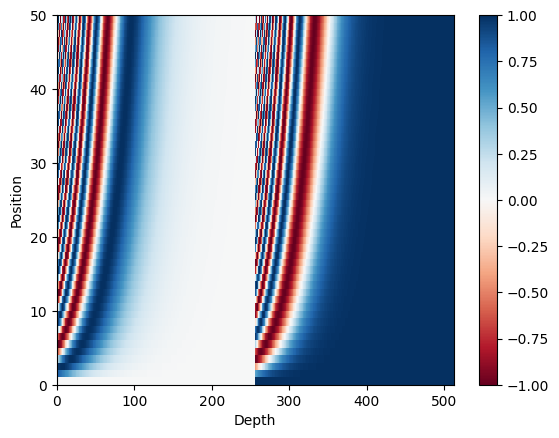

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 512, name="sample_pos_encoding")

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

### Encoder Layer

Mỗi lớp encode bao gồm các lớp sublayers:

1. Multi-head attention (with padding mask) 
2. 2 dense layers followed by dropout

Mỗi lớp sublayers has a residual connection around it followed by a layer normalization. Residual connections giúp tránh vấn đề về the vanishing gradient

Output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")#input sequence
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")#loại bỏ các vị trí padding trong input.


    #tính attention scores của input sequence, với mask được đưa vào để loại bỏ các vị trí padding trong input.
    attention = MultiHeadAttentionLayer(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Encoder

The Encoder consists of:
1.   Input Embedding
2.   Positional Encoding
3.   `num_layers` encoder layers

Đầu vào đi qua lớp embedding nơi nó được cộng với the positional encoding. Đầu ra của phép tổng này là đầu vào của các lớp mã hóa. Đầu ra của bộ mã hóa là đầu vào của bộ giải mã.

In [ ]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    '''
    vocab_size: số lượng từ vựng trong ngôn ngữ đầu vào.
    num_layers: số lượng tầng trong encoder.
    units: số lượng neuron trong mỗi tầng ẩn của mạng nơ-ron trong mỗi tầng encoder.
    d_model: số chiều của word embedding và vector kết quả đầu ra.
    num_heads: số lượng head của multi-head attention trong mỗi tầng encoder.
    dropout: tỉ lệ dropout để giảm overfitting trong mỗi tầng encoder.
    name: tên của encoder.
    '''
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    #biểu diễn thông tin từ câu đầu vào với độ phức tạp ngày càng tăng khi đi từ lớp đầu tiên đến lớp cuối cùng.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Decoder Layer

Mỗi lớp decoder gồm các lớp con:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout

Mỗi lớp con có môt residual connection xung quanh và followed by a layer normalization. Đầu ra của mỗi lớp con `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, các trọng số attention thể hiện tầm quan trọng được gán cho đầu vào của bộ giải mã dựa trên đầu ra của bộ mã hóa. Nói cách khác, bộ giải mã dự đoán từ tiếp theo bằng cách xem đầu ra của bộ mã hóa và tự xử lý đầu ra của chính nó. Xem phần trình diễn ở trên trong phần chú ý của sản phẩm chấm được chia tỷ lệ.

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    #trình tự đầu vào cho lớp này, thường là đầu ra của lớp trước hoặc lớp nhúng.
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    #đầu ra của bộ mã hóa. Điều này được sử dụng làm chuỗi khóa và giá trị cho lớp chú ý đầu tiên của bộ giải mã.
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    #một mặt nạ được sử dụng để ngăn bộ giải mã tham gia vào các mã thông báo trong tương lai theo trình tự trong quá trình tự chú ý.
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    #một mặt nạ được sử dụng để đánh dấu các mã thông báo đệm và ngăn bộ giải mã theo dõi chúng trong lớp chú ý thứ hai.
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)


    '''
    Cụ thể, lớp attention2 có hai bước attention. 
    Đầu tiên, attention được tính toán giữa attention1 và enc_outputs.
    Sau đó, lớp thả (dropout) được áp dụng trên attention2, sau đó kết quả được cộng với attention1 và 
    được chuẩn hóa bằng lớp LayerNormalization. Cuối cùng, đầu ra của lớp được trả về
    '''
    attention2 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

Mục tiêu được đặt thông qua một nhúng được tổng hợp bằng mã hóa vị trí. Đầu ra của phép tổng này là đầu vào của các lớp giải mã. Đầu ra của bộ giải mã là đầu vào của lớp tuyến tính cuối cùng.

In [ ]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):


    '''
    vocab_size: số lượng từ vựng trong ngôn ngữ đầu vào.
    num_layers: số lượng tầng trong decoder.
    units: số lượng neuron trong mỗi tầng ẩn của mạng nơ-ron trong mỗi tầng decoder.
    d_model: số chiều của word embedding và vector kết quả đầu ra.
    num_heads: số lượng head của multi-head attention trong mỗi tầng decoder.
    dropout: tỉ lệ dropout để giảm overfitting trong mỗi tầng decoder.
    name: tên của decoder.
    '''
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    #một lớp dropout được áp dụng để giảm thiểu overfitting.
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

### Transformer

Gồm encoder, decoder and a final linear layer. Đầu ra của bộ giải mã là đầu vào của lớp tuyến tính và đầu ra của nó được trả về.

In [ ]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    '''
    vocab_size: số lượng từ vựng trong bộ dữ liệu.
    num_layers: số lượng layers trong encoder và decoder.
    units: số lượng đơn vị ẩn trong mỗi layer.
    d_model: kích thước của các vector đầu ra của Embedding Layer và cả Encoder/Decoder Layer.
    num_heads: số lượng head trong Multi-head Attention.
    dropout: tỷ lệ dropout giữa các layers.
    name: tên của mô hình.
    '''
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    #outputs được đưa vào một layer Dense để dự đoán các từ tiếp theo của câu đang được tạo ra.
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## Train model

### Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler.

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(
            tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2)
        )

Text(0.5, 0, 'Train Step')

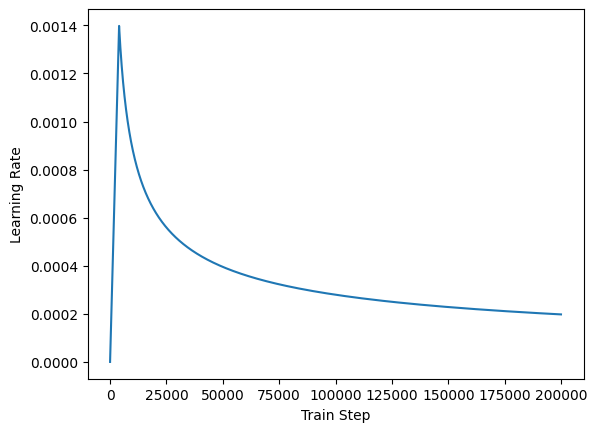

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Initialize and compile model

Initialize and compile model with our predefined custom learning rate and Adam optimizer under the strategy scope.

In [ ]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


# initialize and compile model within strategy scope
with strategy.scope():
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
    )

    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3173632     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### Fit model

Train our transformer by simply calling `model.fit()`

In [ ]:
model.fit(dataset, epochs=EPOCHS)

Epoch 1/40
779/779 [==============================] - 133s 156ms/step - loss: 0.7751 - accuracy: 0.0152
Epoch 2/40
779/779 [==============================] - 125s 160ms/step - loss: 0.5666 - accuracy: 0.0270
Epoch 3/40
779/779 [==============================] - 126s 161ms/step - loss: 0.5317 - accuracy: 0.0295
Epoch 4/40
779/779 [==============================] - 127s 163ms/step - loss: 0.5091 - accuracy: 0.0313
Epoch 5/40
779/779 [==============================] - 127s 163ms/step - loss: 0.4893 - accuracy: 0.0328
Epoch 6/40
779/779 [==============================] - 127s 163ms/step - loss: 0.4710 - accuracy: 0.0340
Epoch 7/40
779/779 [==============================] - 127s 163ms/step - loss: 0.4490 - accuracy: 0.0357
Epoch 8/40
779/779 [==============================] - 126s 162ms/step - loss: 0.4290 - accuracy: 0.0374
Epoch 9/40
779/779 [==============================] - 127s 163ms/step - loss: 0.4109 - accuracy: 0.0392
Epoch 10/40
779/779 [==============================] - 127s 162m

### Save and load model

In [ ]:
filename = "model.h5"
tf.keras.models.save_model(model, filepath=filename, include_optimizer=False)

In [ ]:
del model
tf.keras.backend.clear_session()

In [ ]:
model = tf.keras.models.load_model(
    filename,
    custom_objects={
        "PositionalEncoding": PositionalEncoding,
        "MultiHeadAttentionLayer": MultiHeadAttentionLayer,
    },
    compile=False,
)

## Evaluate and predict


* Áp dụng cùng một phương pháp tiền xử lý mà chúng tôi đã sử dụng để tạo tập dữ liệu cho câu đầu vào.
* Tokenize câu đầu vào và thêm `START_TOKEN`, `END_TOKEN`. 
* Calculate the padding masks and the look ahead masks.
* Sau đó, bộ giải mã đưa ra các dự đoán bằng cách xem xét đầu ra của bộ mã hóa và đầu ra của chính nó.
* Chọn từ cuối cùng và tính argmax của từ đó.
* Nối từ được dự đoán với đầu vào bộ giải mã khi truyền từ đó tới bộ giải mã.
* Trong cách tiếp cận này, bộ giải mã dự đoán từ tiếp theo dựa trên các từ trước đó mà nó đã dự đoán.


In [ ]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )
    return predicted_sentence

Test model!

In [ ]:
predict("Where have you been?")

'i have been here . i have been thinking , have not i ?'

In [ ]:
predict("It's a trap")

'okay , you loved that all four .'

In [ ]:
# feed the model with its previous output
sentence = "I am not crazy, my mother had me tested."
for _ in range(5):
    print(f"Input: {sentence}")
    sentence = predict(sentence)
    print(f"Output: {sentence}\n")

Input: I am not crazy, my mother had me tested.
Output: i thought you said that was a very big questioned er who would be right for a little while . you would be better if you were a clue .

Input: i thought you said that was a very big questioned er who would be right for a little while . you would be better if you were a clue .
Output: the other one .

Input: the other one .
Output: who s the boss ?

Input: who s the boss ?
Output: i do not know . i do not know . i just feel a little sorrier i am on the unicorn .

Input: i do not know . i do not know . i just feel a little sorrier i am on the unicorn .
Output: oh . well , you know .

